In [4]:
# code block for imports 
import pandas as pd 
import numpy as np
import sqlite3
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import pandas as pd
import folium
from folium import plugins
from folium.plugins import HeatMap

In [5]:
conn = sqlite3.connect('cs506MAPC.db')

## Display first 10 Providers 

In [6]:
qrystr ="SELECT DISTINCT t1.ProviderName,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"


#convert query results into dataframe
df_filtered_providers = pd.read_sql_query(qrystr, conn)
print(df_filtered_providers.head(10))

                        ProviderName  MaxAdDown  MaxAdUp      town  Longitude  \
0     MCI Communications Corporation        0.0      0.0  ABINGTON     -70.96   
1             Crown Castle Fiber LLC        0.0      0.0  ABINGTON     -70.96   
2                       ViaSat, Inc.      100.0      3.0  ABINGTON     -70.96   
3             U.S. TelePacific Corp.        0.0      0.0  ABINGTON     -70.96   
4  Broadview Networks Holdings, Inc.        0.0      0.0  ABINGTON     -70.96   
5  COMCAST CABLE COMMUNICATIONS, LLC      987.0     35.0  ABINGTON     -70.96   
6  COMCAST CABLE COMMUNICATIONS, LLC        0.0      0.0  ABINGTON     -70.96   
7            EarthLink Business, LLC        0.0      0.0  ABINGTON     -70.96   
8        PAETEC Communications, Inc.        0.0      0.0  ABINGTON     -70.96   
9                   Spectrotel, Inc.        0.0      0.0  ABINGTON     -70.96   

   Latitude  
0     42.12  
1     42.12  
2     42.12  
3     42.12  
4     42.12  
5     42.12  
6     42.1

## Non Zero Providers

In [7]:
qryStr2 = "SELECT DISTINCT t1.ProviderName,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown != 0.0 AND MaxAdUp != 0.0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"
df_filtered_non_zero_providers = pd.read_sql_query(qryStr2, conn)
print(df_filtered_non_zero_providers.head(10))


                        ProviderName  MaxAdDown  MaxAdUp      town  Longitude  \
0                       ViaSat, Inc.      100.0    3.000  ABINGTON     -70.96   
1  COMCAST CABLE COMMUNICATIONS, LLC      987.0   35.000  ABINGTON     -70.96   
2           Verizon New England Inc.      940.0  880.000  ABINGTON     -70.96   
3           Verizon New England Inc.        5.0    0.768  ABINGTON     -70.96   
4           Verizon New England Inc.       15.0    1.000  ABINGTON     -70.96   
5           Verizon New England Inc.       10.0    1.000  ABINGTON     -70.96   
6           Verizon New England Inc.        7.0    0.768  ABINGTON     -70.96   
7           Verizon New England Inc.        1.5    0.384  ABINGTON     -70.96   
8           Verizon New England Inc.        3.0    0.768  ABINGTON     -70.96   
9           Verizon New England Inc.        1.0    0.384  ABINGTON     -70.96   

   Latitude  
0     42.12  
1     42.12  
2     42.12  
3     42.12  
4     42.12  
5     42.12  
6     42.1

## Zero Providers

In [8]:
qryStr3 = "SELECT DISTINCT t1.ProviderName,t1.MaxAdDown,t1.MaxAdUp, t2.town, t3.Longitude, t3.Latitude FROM FCC_DATA_T t1, censusblocks_t t2, CityLongLat_t t3 WHERE MaxAdDown = 0 AND MaxAdUp = 0 and substr(t1.BlockCode,0,12) = t2.blockcode AND t2.town = t3.town ORDER BY t2.town ASC"
df_filtered_zero_providers = pd.read_sql_query(qryStr3, conn)
print(df_filtered_zero_providers.head(10))

                        ProviderName  MaxAdDown  MaxAdUp             town  \
0     MCI Communications Corporation        0.0      0.0         ABINGTON   
1             Crown Castle Fiber LLC        0.0      0.0         ABINGTON   
2             U.S. TelePacific Corp.        0.0      0.0         ABINGTON   
3  Broadview Networks Holdings, Inc.        0.0      0.0         ABINGTON   
4  COMCAST CABLE COMMUNICATIONS, LLC        0.0      0.0         ABINGTON   
5            EarthLink Business, LLC        0.0      0.0         ABINGTON   
6        PAETEC Communications, Inc.        0.0      0.0         ABINGTON   
7                   Spectrotel, Inc.        0.0      0.0         ABINGTON   
8            GCI Communication Corp.        0.0      0.0         ABINGTON   
9             U.S. TelePacific Corp.        0.0      0.0  ACUSHNET CENTER   

   Longitude  Latitude  
0     -70.96     42.12  
1     -70.96     42.12  
2     -70.96     42.12  
3     -70.96     42.12  
4     -70.96     42.12  
5 

In [9]:
def generateBaseMap(default_location=[42.360081, -71.058884]):
    base_map = folium.Map(location=default_location)
    return base_map

# download speed
base_map = generateBaseMap()

HeatMap(data=df_filtered_non_zero_providers [['Latitude', 'Longitude', 'MaxAdDown']].groupby(['Latitude', 'Longitude']).
        mean().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map) 

base_map.save('maxaddown.html')

# upload speed
base_map = generateBaseMap()

HeatMap(data=df_filtered_non_zero_providers [['Latitude', 'Longitude', 'MaxAdUp']].groupby(['Latitude', 'Longitude']).
        mean().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map) 

base_map.save('maxadup.html')

## Median Income Per Race (Census Tracks)

In [15]:
qryStr4 = "SELECT t2.Town as Town, AVG(t1.mhi) as 'Average Median Income' FROM median_income_t t1, censusblocks_t t2 WHERE t2.blockcode = t1.ct10_id and t1.mhi > 1 GROUP BY t2.Town;"
town_median_income  = pd.read_sql_query(qryStr4, conn)
print(town_median_income.head(10))

              Town  Average Median Income
0         ABINGTON           89531.333333
1  ACUSHNET CENTER           69091.500000
2            ADAMS           50431.000000
3      AGAWAM TOWN           70442.500000
4    AMESBURY TOWN           83022.250000
5   AMHERST CENTER           47272.800000
6          ANDOVER          130214.500000
7        ARLINGTON          110874.250000
8            ATHOL           55275.333333
9        ATTLEBORO           75457.750000


In [22]:
town_median_income.sort_values(by=['Average Median Income'])
top_five_towns = town_median_income.nlargest(5, ['Average Median Income'])
bottom_five_towns = town_median_income.nsmallest(5, ['Average Median Income'])

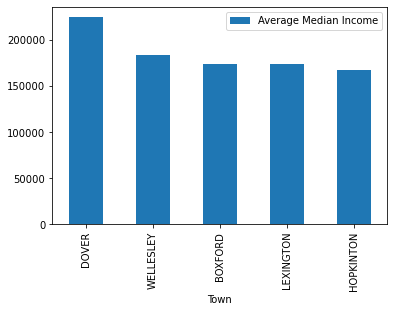

In [23]:
top_five_towns.plot(x='Town', y='Average Median Income', kind='bar') 
plt.show()

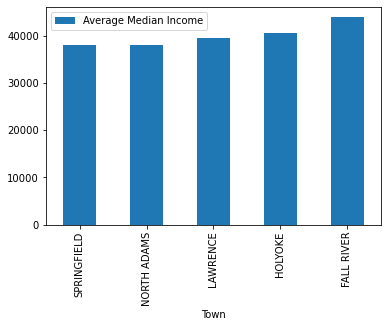

In [24]:
bottom_five_towns.plot(x='Town', y='Average Median Income', kind='bar') 
plt.show()